In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer


# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)       # Adjust the display width to fit the data

In [14]:
df = pd.read_csv("../NY17_24combinedcleaned.csv")

In [18]:
print(df[['TMP', 'WND', 'AA1', 'SLP', 'DEW']].describe())


                 TMP            WND           AA1           SLP            DEW
count  120089.000000  120089.000000  22350.000000  72736.000000  120089.000000
mean       69.897031      86.261243      0.311432   1022.013264     653.647195
std       227.231181     275.609102      0.585993      8.859794    2316.844736
min       -61.000000       0.000000      0.100000    977.300000    -610.000000
25%         7.000000       2.100000      0.100000   1015.200000      10.000000
50%        16.000000       3.100000      0.100000   1023.900000     100.000000
75%        23.300000       4.600000      0.100000   1030.000000     180.000000
max       999.900000     999.900000      2.400000   1048.900000    9999.000000


TMP (Temperature, °C?) - There are extreme outliers (999.9 is likely an error).
WND (Wind Speed, m/s?) - Very high max value suggests errors or misrecordings.
AA1 (Rainfall, mm?)	 - Most values are low (likely light rain).
SLP (Sea Level Pressure, hPa) - Seems normal.
DEW (Dew Point, °C?) - Extreme values suggest errors or missing values.

In [19]:
# Replace extreme values with NaN
df.loc[df['TMP'] > 50, 'TMP'] = np.nan  # Likely errors above 50°C
df.loc[df['WND'] > 150, 'WND'] = np.nan  # Unrealistically high wind speeds
df.loc[df['DEW'] > 50, 'DEW'] = np.nan  # Dew point rarely exceeds 50°C
df.loc[df['SLP'] < 950, 'SLP'] = np.nan  # Pressure below 950 hPa is very rare

In [20]:
def classify_weather(row):
    if row["AA1"] > 5:  # Significant rainfall threshold
        if row["TMP"] < 0:
            return "Snow"  # Cold + precipitation = snow
        elif row["TMP"] > 30:  
            if row["WND"] > 10:  # Strict: Requires strong wind
                return "Thunderstorm"  
            else:  # Flexible: No wind requirement
                return "Thunderstorm"  
        else:
            return "Rainy"  # Otherwise, just rain
    elif row["TMP"] > 35 and row["SLP"] > 1020:
        return "Heatwave"  # High temp + high pressure
    elif row["WND"] > 15:  # Stronger wind needed to classify as Windy
        return "Windy"
    else:
        return "Clear"

df['Weather_Class'] = df.apply(classify_weather, axis=1)


In [21]:
# Select features and target variable
X = df[['WND', 'AA1', 'TMP', 'SLP', 'DEW']]
y = df['Weather_Class']

# Encode target labels into numbers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Accuracy: 1.0
              precision    recall  f1-score   support

       Clear       1.00      1.00      1.00     24017
    Heatwave       1.00      1.00      1.00         1

    accuracy                           1.00     24018
   macro avg       1.00      1.00      1.00     24018
weighted avg       1.00      1.00      1.00     24018



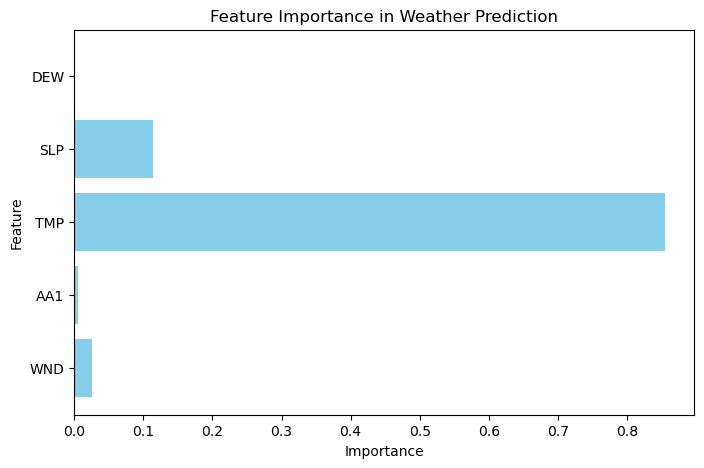

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Weather Prediction')
plt.show()
